Verify the imports
NOTE: Please do NOT edit this panel! 

In [1]:
print('* Verifying the packages')
# System packages 
import os
import pathlib 
import sys 
import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

# Internal packages 
from core import file_utils
from core import optical_flow
from core import video_processing
from core import plotting
from core import msd
from core import inference

print('\t* All required packages were successfully imported!')

* Verifying the packages
	* All required packages were successfully imported!


In [11]:
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 
# Input video sequence (single sequence)   
video_sequence = '%s/../data/microscopes/h2b/u2os-h2bgfp-serum-3.avi' % os.getcwd() # parameters of this sequence: pixel_size=0.088, dt=0.200
#video_sequence = '%s/../data/microscopes/dna/3.avi' % os.getcwd()                    # parameters of this sequence: pixel_size=0.065, dt=0.200
nameOutput='u2os-h2bgfp-serum-3'

# Pixel threshold
pixel_threshold = 100

# Pixel size (should be in microns)
pixel_size = 0.088

# Time step (should be in seconds)
dt = 0.200 

# Output directory 
root_output_directory = '%s/../output-paper/' % os.getcwd()
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 

In [12]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Verify the input parameters, and return the path where the output data will be written  
output_directory = file_utils.veryify_input_options(
    video_sequence=video_sequence, output_directory=root_output_directory, 
    pixel_threshold=pixel_threshold, pixel_size=pixel_size, dt=dt)

# Load the frames from the video 
print('* Loading frames')
frames = video_processing.get_frames_list_from_video(
    video_path=video_sequence, verbose=True)
print('\t* Frames loaded!')
################# PLEASE DON'T EDIT THIS PANEL #################

NOTE: The output path [/ssd1/projects/hidpy/notebooks/../output-paper/] exists
* Loading frames
	* Video Details: 
  	* Name: /ssd1/projects/hidpy/notebooks/../data/microscopes/h2b/u2os-h2bgfp-serum-3.avi 
  	* Number Frames 150  	* FPS: 7.000000


100%|██████████████████████████████████████████████████| 150/150 [00:00<00:00, 259.03it/s]

	* Frames loaded!


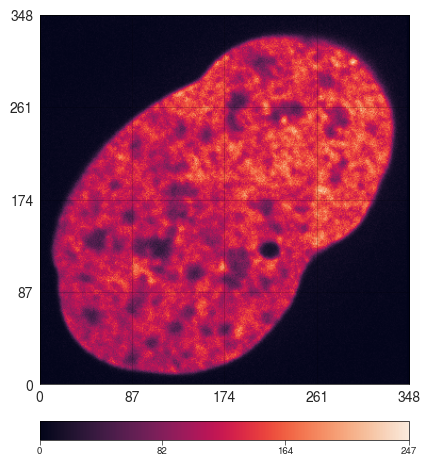

In [13]:
# Plot the first frames
plotting.plot_frame(frame=frames[0], output_directory=output_directory, frame_prefix='input_sequence_frame_0')

In [14]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Compute the optical flow
print('* Computing optical flow') 
u, v = optical_flow.compute_optical_flow_farneback(frames=frames)
print('\t* Optical flow computed!\n') 

# Interpolate the flow field
print('* Computing interpolations')
u, v = optical_flow.interpolate_flow_fields(u_arrays=u, v_arrays=v)
print('\t* Interpolations computed!\n')

# Compute the trajectories 
print('* Creating trajectories')
trajectories = optical_flow.compute_trajectories(
    frame=frames[0], fu_arrays=u, fv_arrays=v, pixel_threshold=pixel_threshold)
print('\t* Trajectories created!\n')

# Plot the trajectories 
print('* Plotting trajectories')
plotting.plot_trajectories_on_frame(
    frame=frames[0], trajectories=trajectories, 
    output_path='%s/trajectories' % output_directory)
print('\t* Trajectories rendered!\n')

################## PLEASE DON'T EDIT THIS PANEL #################

* Computing optical flow


100%|██████████████████████████████████████████████████| 149/149 [00:03<00:00, 48.35it/s]


Optical flow time 3.083490
	* Optical flow computed!

* Computing interpolations


100%|██████████████████████████████████████████████████| 149/149 [00:01<00:00, 94.03it/s]


	* Interpolations computed!

* Creating trajectories


100%|██████████████████████████████████████████████████| 348/348 [02:34<00:00,  2.26it/s]


	* Trajectories created!

* Plotting trajectories
	* Trajectories rendered!



In [15]:
# Calculation of the MSD (mean square displacement)

# Construct trajectory map
print('* Converting the trajectories to maps')
xp, yp = msd.convert_trajectories_to_map(trajectories, (len(frames), frames[0].shape[0], frames[0].shape[1]))

# Convert displacement to microns
xp_um=xp*pixel_size
yp_um=yp*pixel_size

# extract nucleoli mask
print('* Extracting the nucleoli map')
mask_nucleoli = msd.extract_nucleoli_map(xp_um, yp_um)

# Compute the MSDs
print('* Computing the MSDs')
MSD = msd.calculate_msd_for_every_pixel(xp_um, yp_um, mask_nucleoli)

# Baysian fit on MSDs
print('* Fitting the MSDs models using Bayesian inference')

### THIS SHOULD BE SELECTED FROM THE CONFIG FILE 
models_selected = ['D','DA','V','DV','DAV'] 

# THE TIME STEP SHOULD BE SET IN THE CONFIG GILE 
dT = dt
Bayes = inference.apply_bayesian_inference(MSD, dT, models_selected)

* Converting the trajectories to maps
* Extracting the nucleoli map
* Computing the MSDs
* Fitting the MSDs models using Bayesian inference
Bayesian inference..
Using # cores:8


  0%|          | 8/53695 [00:00<51:09, 17.49it/s]  <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<fro

  0%|          | 232/53695 [00:04<12:31, 71.17it/s]

  1%|          | 296/53695 [00:05<20:09, 44.15it/s]

  1%|          | 328/53695 [00:06<21:14, 41.87it/s]

  1%|          | 616/53695 [00:13<22:04, 40.08it/s]

  1%|          | 664/53695 [00:14<20:50, 42.42it/s]

  1%|▏         | 680/53695 [00:14<20:01, 44.12it/s]

  1%|▏         | 696/53695 [00:15<19:38, 44.98it/s]

  1%|▏         | 760/53695 [00:16<19:33, 45.10it/s]

  2%|▏         | 840/53695 [00:18<21:36, 40.78it/s]

  2%|▏         | 920/53695 [00:20<19:47, 44.45it/s]

  2%|▏         | 1096/53695 [00:23<18:39, 47.00it/s]

  3%|▎         | 1400/53695 [00:30<18:22, 47.42it/s]

  3%|▎         | 1496/53695 [00:32<17:54, 48.57it/s]

  3%|▎         | 1720/53695 [00:37<19:54, 43.52it/s]

  4%|▎         | 1896/53695 [00:41<20:17, 42.55it/s]

  4%|▍         | 2024/53695 [00:44<18:50, 45.71it/s]

  4%|▍         | 2056/53695 [00:44<17:32, 49.07it/s]

  5%|▍         | 2472/53695 [00:54<18:32, 46.05it/s]

  5%|▌         | 2728/53695 [00:59<18:18, 46.38it/s]

  5%|▌         | 2776/53695 [01:00<18:49, 45.07it/s]

  5%|▌         | 2920/53695 [01:03<17:57, 47.11it/s]

  6%|▌         | 3240/53695 [01:11<19:25, 43.29it/s]

  7%|▋         | 3496/53695 [01:17<20:31, 40.77it/s]

  7%|▋         | 3880/53695 [01:25<19:14, 43.17it/s]

  7%|▋         | 3992/53695 [01:28<19:00, 43.58it/s]

  8%|▊         | 4120/53695 [01:31<16:54, 48.84it/s]

  8%|▊         | 4184/53695 [01:32<16:46, 49.21it/s]

  8%|▊         | 4264/53695 [01:34<17:58, 45.82it/s]

  8%|▊         | 4408/53695 [01:37<17:42, 46.40it/s]

  9%|▊         | 4632/53695 [01:42<16:33, 49.39it/s]

  9%|▉         | 4760/53695 [01:44<17:02, 47.88it/s]

  9%|▉         | 4904/53695 [01:47<17:28, 46.52it/s]

  9%|▉         | 5048/53695 [01:51<17:17, 46.89it/s]

 10%|▉         | 5160/53695 [01:53<18:01, 44.88it/s]

 10%|▉         | 5176/53695 [01:53<17:04, 47.37it/s]

 10%|█         | 5416/53695 [01:58<17:03, 47.17it/s]

 10%|█         | 5432/53695 [01:59<16:56, 47.48it/s]

 11%|█         | 5656/53695 [02:04<17:01, 47.04it/s]

 11%|█         | 5784/53695 [02:07<17:09, 46.54it/s]

 11%|█         | 5896/53695 [02:09<17:03, 46.71it/s]

 11%|█         | 5928/53695 [02:10<17:23, 45.80it/s]

 12%|█▏        | 6184/53695 [02:16<17:17, 45.78it/s]

 12%|█▏        | 6312/53695 [02:19<18:02, 43.78it/s]

 12%|█▏        | 6328/53695 [02:19<19:32, 40.39it/s]

 12%|█▏        | 6584/53695 [02:25<20:55, 37.52it/s]

 13%|█▎        | 6728/53695 [02:29<17:55, 43.67it/s]

 13%|█▎        | 6904/53695 [02:33<18:15, 42.72it/s]

 13%|█▎        | 7176/53695 [02:39<17:44, 43.71it/s]

 14%|█▍        | 7400/53695 [02:44<16:05, 47.97it/s]

 14%|█▍        | 7768/53695 [02:53<17:25, 43.93it/s]

 15%|█▍        | 7816/53695 [02:54<17:26, 43.84it/s]

 15%|█▍        | 7992/53695 [02:57<16:16, 46.82it/s]

 15%|█▍        | 8040/53695 [02:58<16:29, 46.12it/s]

 15%|█▌        | 8104/53695 [03:00<16:38, 45.66it/s]

 15%|█▌        | 8152/53695 [03:01<15:32, 48.84it/s]

 16%|█▌        | 8424/53695 [03:07<16:06, 46.83it/s]

 16%|█▌        | 8520/53695 [03:09<16:47, 44.86it/s]

 16%|█▌        | 8600/53695 [03:11<17:52, 42.03it/s]

 17%|█▋        | 9176/53695 [03:24<15:57, 46.51it/s]

 17%|█▋        | 9272/53695 [03:26<14:53, 49.69it/s]

 18%|█▊        | 9448/53695 [03:30<17:03, 43.24it/s]

 18%|█▊        | 9640/53695 [03:34<15:17, 48.00it/s]

 18%|█▊        | 9704/53695 [03:35<16:30, 44.43it/s]

 18%|█▊        | 9816/53695 [03:38<16:14, 45.02it/s]

 19%|█▉        | 10168/53695 [03:46<15:35, 46.50it/s]

 19%|█▉        | 10200/53695 [03:47<15:44, 46.04it/s]

 19%|█▉        | 10280/53695 [03:49<16:11, 44.67it/s]

 20%|█▉        | 10520/53695 [03:54<15:53, 45.27it/s]

 20%|█▉        | 10552/53695 [03:54<14:57, 48.06it/s]

 20%|██        | 10856/53695 [04:01<15:23, 46.40it/s]

 20%|██        | 10968/53695 [04:03<14:59, 47.49it/s]

 21%|██        | 11208/53695 [04:09<15:33, 45.53it/s]

 21%|██        | 11240/53695 [04:10<14:39, 48.25it/s]

 21%|██        | 11384/53695 [04:13<15:03, 46.83it/s]

 21%|██▏       | 11512/53695 [04:16<15:32, 45.25it/s]

 22%|██▏       | 11656/53695 [04:19<16:25, 42.65it/s]

 22%|██▏       | 11816/53695 [04:23<15:24, 45.29it/s]

 22%|██▏       | 11960/53695 [04:26<15:57, 43.58it/s]

 23%|██▎       | 12216/53695 [04:32<14:48, 46.66it/s]

 23%|██▎       | 12488/53695 [04:38<15:45, 43.60it/s]

 24%|██▍       | 13080/53695 [04:51<14:41, 46.08it/s]

 26%|██▋       | 14184/53695 [05:16<13:18, 49.49it/s]

 27%|██▋       | 14344/53695 [05:20<14:44, 44.48it/s]

 27%|██▋       | 14536/53695 [05:24<14:41, 44.42it/s]

 27%|██▋       | 14664/53695 [05:27<15:18, 42.51it/s]

 28%|██▊       | 14872/53695 [05:32<14:23, 44.99it/s]

 28%|██▊       | 14968/53695 [05:34<13:36, 47.46it/s]

 28%|██▊       | 15016/53695 [05:35<14:02, 45.90it/s]

 28%|██▊       | 15096/53695 [05:36<13:47, 46.62it/s]

 29%|██▊       | 15320/53695 [05:42<15:39, 40.83it/s]

 29%|██▉       | 15656/53695 [05:50<14:18, 44.29it/s]

 30%|███       | 16328/53695 [06:05<14:11, 43.88it/s]

 31%|███       | 16440/53695 [06:08<13:44, 45.16it/s]

 31%|███       | 16568/53695 [06:11<13:36, 45.44it/s]

 31%|███       | 16648/53695 [06:12<14:08, 43.64it/s]

 31%|███       | 16744/53695 [06:14<13:43, 44.87it/s]

 31%|███       | 16776/53695 [06:15<13:31, 45.50it/s]

 31%|███▏      | 16904/53695 [06:18<13:51, 44.24it/s]

 32%|███▏      | 16952/53695 [06:19<14:05, 43.45it/s]

 32%|███▏      | 17304/53695 [06:27<13:25, 45.16it/s]

 32%|███▏      | 17352/53695 [06:28<13:09, 46.01it/s]

 33%|███▎      | 17784/53695 [06:38<13:24, 44.62it/s]

 34%|███▍      | 18136/53695 [06:46<12:35, 47.07it/s]

 34%|███▍      | 18184/53695 [06:47<13:01, 45.46it/s]

 34%|███▍      | 18200/53695 [06:47<12:54, 45.82it/s]

 34%|███▍      | 18216/53695 [06:48<12:25, 47.60it/s]

 34%|███▍      | 18280/53695 [06:49<13:23, 44.07it/s]

 34%|███▍      | 18328/53695 [06:50<13:30, 43.64it/s]

 35%|███▍      | 18552/53695 [06:55<12:46, 45.87it/s]

 35%|███▍      | 18680/53695 [06:58<13:44, 42.46it/s]

 38%|███▊      | 20440/53695 [07:37<11:42, 47.34it/s]

 39%|███▉      | 21176/53695 [07:54<12:24, 43.66it/s]

 40%|███▉      | 21400/53695 [07:59<12:02, 44.72it/s]

 40%|████      | 21720/53695 [08:06<11:16, 47.28it/s]

 41%|████      | 21960/53695 [08:11<12:23, 42.69it/s]

 41%|████▏     | 22248/53695 [08:18<11:51, 44.17it/s]

 42%|████▏     | 22360/53695 [08:20<11:02, 47.30it/s]

 42%|████▏     | 22488/53695 [08:23<10:53, 47.72it/s]

 43%|████▎     | 22840/53695 [08:31<12:23, 41.47it/s]

 43%|████▎     | 22920/53695 [08:33<12:14, 41.89it/s]

 43%|████▎     | 23048/53695 [08:36<11:23, 44.82it/s]

 43%|████▎     | 23288/53695 [08:41<11:12, 45.24it/s]

 44%|████▎     | 23432/53695 [08:44<11:22, 44.35it/s]

 44%|████▍     | 23496/53695 [08:45<11:07, 45.25it/s]

 44%|████▍     | 23544/53695 [08:46<09:53, 50.77it/s]

 44%|████▍     | 23784/53695 [08:52<11:12, 44.50it/s]

 45%|████▍     | 24008/53695 [08:56<10:07, 48.88it/s]

 45%|████▍     | 24120/53695 [08:59<10:15, 48.09it/s]

 46%|████▌     | 24488/53695 [09:06<09:41, 50.27it/s]

 47%|████▋     | 25080/53695 [09:18<09:58, 47.79it/s]

 50%|████▉     | 26648/53695 [09:53<09:56, 45.35it/s]

 51%|█████     | 27368/53695 [10:08<09:42, 45.16it/s]

 52%|█████▏    | 27832/53695 [10:19<09:03, 47.60it/s]

 54%|█████▎    | 28744/53695 [10:39<09:28, 43.89it/s]

 56%|█████▌    | 30024/53695 [11:08<08:56, 44.11it/s]

 57%|█████▋    | 30552/53695 [11:20<08:45, 44.02it/s]

 58%|█████▊    | 31368/53695 [11:38<08:09, 45.60it/s]

 59%|█████▊    | 31432/53695 [11:39<07:15, 51.10it/s]

 59%|█████▉    | 31624/53695 [11:43<08:31, 43.15it/s]

 59%|█████▉    | 31672/53695 [11:45<08:39, 42.39it/s]

 60%|█████▉    | 32168/53695 [11:56<07:52, 45.58it/s]

 60%|██████    | 32408/53695 [12:01<07:09, 49.55it/s]

 61%|██████    | 32648/53695 [12:06<07:37, 46.05it/s]

 62%|██████▏   | 33384/53695 [12:23<07:12, 47.00it/s]

 64%|██████▍   | 34424/53695 [12:46<06:42, 47.90it/s]

 65%|██████▍   | 34664/53695 [12:51<07:03, 44.98it/s]

 65%|██████▌   | 35144/53695 [13:02<06:55, 44.67it/s]

 66%|██████▌   | 35432/53695 [13:08<06:57, 43.74it/s]

 67%|██████▋   | 35912/53695 [13:19<06:34, 45.10it/s]

 72%|███████▏  | 38664/53695 [14:20<05:50, 42.91it/s]

 73%|███████▎  | 39400/53695 [14:37<05:09, 46.22it/s]

 73%|███████▎  | 39432/53695 [14:37<05:29, 43.29it/s]

 74%|███████▍  | 39896/53695 [14:48<05:09, 44.65it/s]

 75%|███████▍  | 40216/53695 [14:56<05:10, 43.35it/s]

 77%|███████▋  | 41288/53695 [15:20<04:45, 43.39it/s]

 78%|███████▊  | 41720/53695 [15:29<04:27, 44.71it/s]

 79%|███████▊  | 42232/53695 [15:40<04:16, 44.69it/s]

 79%|███████▉  | 42312/53695 [15:42<03:51, 49.22it/s]

 79%|███████▉  | 42680/53695 [15:50<03:48, 48.22it/s]

 80%|███████▉  | 42952/53695 [15:56<03:52, 46.29it/s]

 82%|████████▏ | 43896/53695 [16:16<03:31, 46.22it/s]

 83%|████████▎ | 44408/53695 [16:28<03:24, 45.38it/s]

 83%|████████▎ | 44472/53695 [16:29<03:49, 40.16it/s]

 83%|████████▎ | 44808/53695 [16:37<03:19, 44.46it/s]

 88%|████████▊ | 47496/53695 [17:35<02:01, 51.10it/s]

 89%|████████▉ | 47864/53695 [17:43<02:09, 45.19it/s]

 92%|█████████▏| 49176/53695 [18:13<01:34, 47.69it/s]

 92%|█████████▏| 49608/53695 [18:22<01:25, 47.74it/s]

 93%|█████████▎| 50008/53695 [18:31<01:17, 47.34it/s]

 94%|█████████▎| 50248/53695 [18:36<01:17, 44.46it/s]

 94%|█████████▍| 50392/53695 [18:39<01:13, 44.87it/s]

 94%|█████████▍| 50536/53695 [18:42<01:10, 44.56it/s]

 95%|█████████▍| 50792/53695 [18:48<01:05, 44.04it/s]

 95%|█████████▍| 50936/53695 [18:51<00:56, 49.24it/s]

 96%|█████████▌| 51432/53695 [19:02<00:46, 48.71it/s]

 96%|█████████▌| 51624/53695 [19:06<00:46, 44.76it/s]

 96%|█████████▋| 51768/53695 [19:09<00:42, 45.63it/s]

 97%|█████████▋| 51880/53695 [19:11<00:38, 47.26it/s]

 97%|█████████▋| 52184/53695 [19:18<00:33, 45.68it/s]

 97%|█████████▋| 52280/53695 [19:20<00:31, 45.33it/s]

 99%|█████████▉| 53176/53695 [19:40<00:11, 43.56it/s]

 99%|█████████▉| 53400/53695 [19:45<00:06, 47.53it/s]

100%|█████████▉| 53464/53695 [19:46<00:04, 48.80it/s]

100%|█████████▉| 53672/53695 [19:51<00:00, 49.25it/s]

100%|██████████| 53695/53695 [01:02<00:00, 857.92it/s]


In [58]:
# Plot the raw image

# Plot the model selection 

####################################################################################################
# @sample_range
####################################################################################################
def sample_range(start,
                 end,
                 steps):

    # Delta
    delta = 1. * (end - start) / (steps - 1)

    # Data
    data = list()
    for i in range(steps):
        value = start + i * delta
        data.append(value)

    return data


# Plot the D, A and V 
def plot_matrix(matrix, output_directory, frame_prefix, font_size=10):

    from matplotlib import colors, pyplot
    import seaborn


    #verify_plotting_packages()
    
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'

    # Plot 
    fig, ax = pyplot.subplots()
    
    # Create the ticks of the images 
    xticks = sample_range(0, matrix.shape[0], 5)
    yticks = sample_range(0, matrix.shape[1], 5)

    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

    cmap = colors.ListedColormap(['w','g','b','purple','r','greenyellow'])
    
    # Show the image 
    im = pyplot.imshow(matrix,  interpolation='nearest',cmap=cmap,origin='lower')
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    # Color-basr axis 
    cax = ax.inset_axes([0.00, -0.15, 1.0, 0.05])

    # Color-bar 
    import numpy
    cb = pyplot.colorbar(im, ax=ax, cax=cax, spacing='proportional',orientation='horizontal', boundaries=[-0.5] + bounds + [5.5])
    cb.ax.tick_params(labelsize=int(font_size * 0.75), width=0.5) 
    labels = numpy.arange(0, 6, 1)
    loc = labels
    cb.set_ticks(loc)
    cb.set_ticklabels([' ','D','DA','V','DV','DAV'])
    ax.set_title('Model Selection')

    # Save the figure 
    pyplot.savefig('%s/%s.png' % (output_directory, frame_prefix), dpi=300, bbox_inches='tight', pad_inches=0)


In [113]:

# Plot the D, A and V 
def plot_other(matrix, matrix1, output_directory, frame_prefix, font_size=10, title='Title'):

    from matplotlib import colors, pyplot
    import seaborn


    #verify_plotting_packages()
    
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'

    # Plot 
    pyplot.clf
    fig, ax = pyplot.subplots()

    print(matrix)
    
    # Create the ticks of the images 
    xticks = sample_range(0, matrix.shape[0], 5)
    yticks = sample_range(0, matrix.shape[1], 5)

    # Show the image 
    im = pyplot.imshow(matrix, interpolation='nearest',cmap='viridis',origin='lower')
    ax.contour(matrix1, colors='k', origin='lower')
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_title(title)
    
    # Color-basr axis 
    cax = ax.inset_axes([0.00, -0.15, 1.0, 0.05])

    import numpy
    
    # Create the ticks based on the range 
    #cbticks = sample_range((matrix.min()), (matrix.max()), 4)
    #print(cbticks)

    #cbticks = list(map(int, cbticks))
    
    # Convert the ticks to a numpy array 
    #cbticks = numpy.array(cbticks)

    # Color-bar 
    cb = pyplot.colorbar(im, ax=ax, cax=cax, spacing='proportional',orientation='horizontal')
    cb.ax.tick_params(labelsize=int(font_size * 0.75), width=0.5) 
    #cb.ax.set_xlim((cbticks[0], cbticks[-1]))
    ax.set_title(title)

    # Save the figure 
    pyplot.savefig('%s/%s.png' % (output_directory, frame_prefix), dpi=300, bbox_inches='tight', pad_inches=0)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


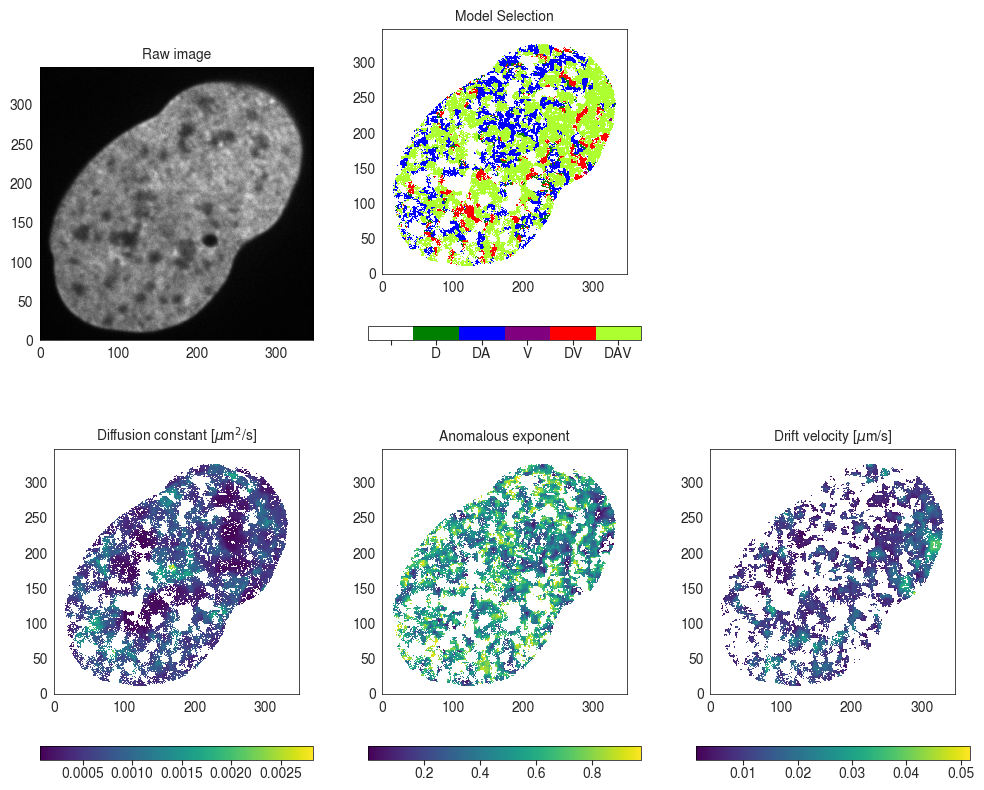

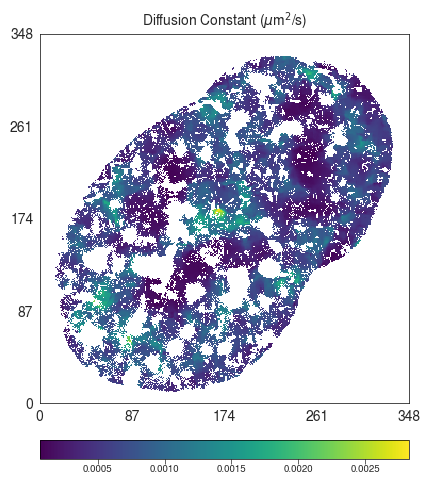

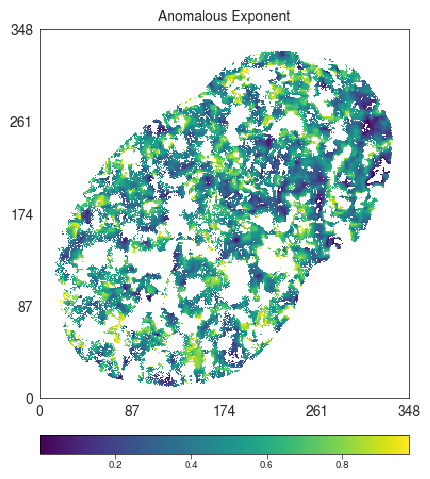

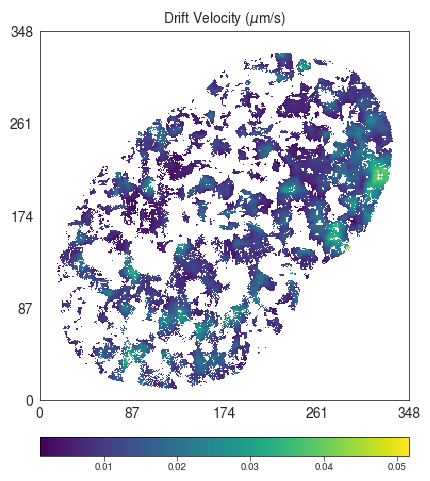

In [118]:
from pylab import *
from matplotlib import colors

matrix1=np.zeros((frames[0].shape[0],frames[0].shape[1]))
matrix1[np.where(mask_nucleoli==1)]=100

bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

fig,ax=plt.subplots(2,3,figsize=[12,10])
ax[0,2].axis('off')

img0=ax[0,0].imshow(frames[0],origin='lower',cmap='gray')
ax[0,0].set_title('Raw image')

cmap = colors.ListedColormap(['w','g','b','purple','r','greenyellow'])
img1=ax[0,1].imshow(Bayes['model'], interpolation='nearest',cmap=cmap,origin='lower')
ax[0,1].contour(matrix1, colors='k', origin='lower')

cbar=fig.colorbar(img1,ax=ax[0,1],spacing='proportional',orientation='horizontal',boundaries=[-0.5] + bounds + [5.5])
labels = np.arange(0, 6, 1)
loc = labels
cbar.set_ticks(loc)
cbar.set_ticklabels([' ','D','DA','V','DV','DAV'])
ax[0,1].set_title('Model Selection')

matD=[]
matD=Bayes['D']
matD[np.where(Bayes['model']==0)]=np.nan
matD[np.where(Bayes['D']<1e-10)]=np.nan

# #figure(2)
img2=ax[1,0].imshow(matD, interpolation='nearest', cmap='viridis', origin='lower')
ax[1,0].contour(matrix1, colors='k', origin='lower')
cbarD=fig.colorbar(img2, ax=ax[1,0],spacing='proportional',orientation='horizontal')
ax[1,0].set_title(r'Diffusion constant [$\mu$m$^2$/s]')

matA=[]
matA=Bayes['A']
matA[np.where(Bayes['model']==0)]=np.nan
matA[np.where(Bayes['A']<1e-10)]=np.nan

# #figure(3)
img3=ax[1,1].imshow(matA, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,1].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img3,ax=ax[1,1],spacing='proportional',orientation='horizontal')
ax[1,1].set_title('Anomalous exponent')

matV=[]
matV=Bayes['V']
matV[np.where(Bayes['model']==0)]=np.nan
matV[np.where(Bayes['V']==0)]=np.nan

# #figure(4)
img4=ax[1,2].imshow(matV, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,2].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img4,ax=ax[1,2],spacing='proportional',orientation='horizontal')
ax[1,2].set_title(r'Drift velocity [$\mu$m/s]')




plot_other(matrix=matD, matrix1=matrix1, output_directory='/projects/hidpy/output-paper/u2os-h2bgfp-serum-3/100_ex_ex', frame_prefix='mat_d', font_size=10, title=r'Diffusion Constant ($\mu$m$^2$/s)')

plot_other(matrix=matA, matrix1=matrix1, output_directory='/projects/hidpy/output-paper/u2os-h2bgfp-serum-3/100_ex_ex', frame_prefix='mat_a', font_size=10, title='Anomalous Exponent')

plot_other(matrix=matV, matrix1=matrix1, output_directory='/projects/hidpy/output-paper/u2os-h2bgfp-serum-3/100_ex_ex', frame_prefix='mat_v', font_size=10, title=r'Drift Velocity ($\mu$m/s)')


In [17]:
# Save pickle file per cell

import pickle

output_b = output_directory +"/" + str(pixel_threshold)+ "_" + "ex_ex"
os.mkdir(output_b)

with open(output_b+'/Results_Bayes_'+nameOutput+'_'+str(pixel_threshold) +'.pickle', 'wb') as f:
#with open('%s/Results_Bayes_04102022_Cell01.pickle' % output_b, 'wb') as f:
    pickle.dump(Bayes, f)